# INM706 - Deep Learning for Sequence Analysis

Authors: Laerte Adami - Elisa Troschka

In [9]:
# Custom functionalities
from Utilities.lstmHandler import EncoderLSTM, DecoderLSTM, AttentionDecoderLSTM
from Utilities.modelHandler import LSTModel
from Utilities.LanguageDataset import LanguageDataset

import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss as CEL
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.rcParams['font.size'] = 17

In [10]:
## DATASET PARAMETERS ##
data_path = "Data/eng_ita.tsv"
limit_data = 200000
start_token = '<BoS>'
end_token = '<EoS>'
seq_len = 15
embedding_size = 256#1024
batch_size = 50

# Import datasets
dataset = LanguageDataset(data_path = data_path, start_token = start_token, end_token = end_token, seq_len = seq_len, limit_data = limit_data)
train_set, val_set, test_set = dataset.get_datasets()

end_index = dataset.from_ita[end_token]
start_index = dataset.from_ita[start_token]

# Create dataloaders
trainloader = DataLoader(train_set, batch_size = batch_size)
valloader = DataLoader(val_set, batch_size = batch_size)
testloader = DataLoader(test_set, batch_size = batch_size)

# Vocabulary for BLUE score
blue_voc = dataset.blue_score_test

print("English vocabulary size for training: {}".format(dataset.eng_voc_size))
print("Italian vocabulary size for training: {}".format(dataset.ita_voc_size))
print("--------------------------------------------")
print("Train set dimension: {}".format(train_set.__len__()))
print("Val set dimension: {}".format(val_set.__len__()))
print("Test set dimension: {}".format(test_set.__len__()))

English vocabulary size for training: 18639
Italian vocabulary size for training: 31632
--------------------------------------------
Train set dimension: 140082
Val set dimension: 19888
Test set dimension: 40030


## Model defition

In [11]:
encoder = EncoderLSTM(vocabulary_size = dataset.eng_voc_size,
                     embedding_size = embedding_size,
                     num_layers = 1, 
                     bidirectional = True)

#decoder = DecoderLSTM(vocabulary_size = dataset.ita_voc_size,
#                     embedding_size = embedding_size,
#                     num_layers = 1, 
#                     bidirectional = False)

decoder = AttentionDecoderLSTM(vocabulary_size = dataset.ita_voc_size,
                     embedding_size = embedding_size,
                     seq_len = dataset.seq_len,
                     num_layers = 1, 
                     bidirectional = True)

loss_func = CEL()
learning_rate = 1e-4
model = LSTModel(encoder = encoder, 
                 decoder = decoder, 
                 encoder_optimizer = Adam(encoder.parameters(), lr = learning_rate), 
                 decoder_optimizer = Adam(decoder.parameters(), lr = learning_rate),
                 loss_function = loss_func, 
                 eos_token = end_index, 
                 bos_token = start_index)

## Model training

Working on cuda
EPOCH 1: train loss = 2.867, validation loss = 2.558
EPOCH 2: train loss = 2.371, validation loss = 2.324
EPOCH 3: train loss = 2.112, validation loss = 2.167
EPOCH 4: train loss = 1.905, validation loss = 2.057
EPOCH 5: train loss = 1.734, validation loss = 1.986
EPOCH 6: train loss = 1.59, validation loss = 1.915
EPOCH 7: train loss = 1.467, validation loss = 1.859
EPOCH 8: train loss = 1.362, validation loss = 1.817
EPOCH 9: train loss = 1.275, validation loss = 1.791
EPOCH 10: train loss = 1.199, validation loss = 1.763
EPOCH 11: train loss = 1.129, validation loss = 1.744
EPOCH 12: train loss = 1.07, validation loss = 1.735
EPOCH 13: train loss = 1.024, validation loss = 1.719
EPOCH 14: train loss = 0.982, validation loss = 1.712
EPOCH 15: train loss = 0.935, validation loss = 1.711
EPOCH 16: train loss = 0.894, validation loss = 1.71
EPOCH 17: train loss = 0.864, validation loss = 1.706
EPOCH 18: train loss = 0.85, validation loss = 1.732
EPOCH 19: train loss = 0.

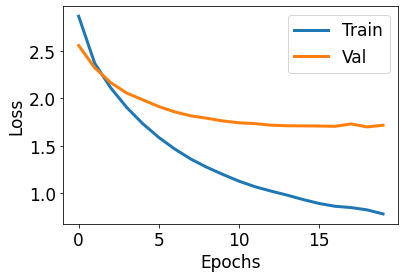

In [12]:
start_time = time.time()
L_train, L_val = model.train_model(trainloader,
                      valloader,
                      max_epochs = 20,
                      save_every_epochs = 10,
                      ckp_name = 'test_name')
print("--------------------------------")
print("Time required: {}".format(time.time()-start_time))
      
fig, ax = plt.subplots()
ax.plot(L_train, linewidth = 3, label = "Train")
ax.plot(L_val, linewidth = 3, label = "Val")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend();

## Model evaluation

In [13]:
enc_ckp = "test_name_enc_10.pth"
dec_ckp = "test_name_dec_10.pth"

X, y, trans = model.evaluate_model(testloader)#, enc_ckp = enc_ckp, dec_ckp = dec_ckp)

X_blue = dataset.translate(X,"eng")
y_blue = dataset.translate(y,"ita")
trans_blue = dataset.translate(trans,"ita")

In [14]:
ids = 26
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: He often eats fish for dinner
Italian: Lui mangia spesso del pesce per cena
Translation: Lui mangia per per per


In [15]:
ids = 34
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: Have you lost your tongue Why don t you answer
Italian: Hai perso la lingua Perché non rispondi
Translation: Hai la la tua non non hai


In [16]:
ids = 2
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: Tom was a very funny man
Italian: Tom era un uomo molto divertente
Translation: Tom era un uomo uomo


## BLUE score

In [18]:
from Utilities.TorchtextMetrics import bleu_score

In [20]:
id_test = 337

candidate_corpus = [trans_blue[id_test]]
reference_corpus = [blue_voc[' '.join(X_blue[id_test])]]

print(f"Candidate corpus: {candidate_corpus}")
print(f"Reference corpus: {reference_corpus}")
print("----------------")
bs = bleu_score(candidate_corpus, reference_corpus, max_n = 1, weights=[1])#[0.5, 0.5])
print(f"Blue score : {bs}")
print("----------------")

Candidate corpus: [['C', 'è', 'una', 'vicino', 'vicino', 'vicino', 'casa', 'casa']]
Reference corpus: [[['C', 'è', 'una', 'chiesa', 'di', 'fianco', 'a', 'casa', 'mia'], ['C', 'è', 'una', 'chiesa', 'di', 'fianco', 'alla', 'mia', 'casa'], ['C', 'è', 'una', 'chiesa', 'accanto', 'a', 'casa', 'mia'], ['C', 'è', 'una', 'chiesa', 'accanto', 'alla', 'mia', 'casa']]]
----------------
Blue score : 0.5
----------------


In [21]:
bs_list = []

for id_test, test in enumerate (trans_blue):
    candidate_corpus = [trans_blue[id_test]]
    reference_corpus = [blue_voc[' '.join(X_blue[id_test])]]
        
    bs = bleu_score(candidate_corpus, reference_corpus, max_n = 3, weights=[0.33, 0.33, 0.33])
    bs_list.append(bs)
    
mean_bleu_score = sum(bs_list)/len(bs_list)

In [5]:
print("Mean BLEU score: {}".format(round(mean_bleu_score,3)))

Mean BLEU score: 0.126
